In [61]:
import pyvisa as visa
from time import sleep
import matplotlib.pyplot as plt
import numpy as np
import time
from edes.modules.detection.detection_utils import plot, plot_ax, big_plt_font

big_plt_font()
rm = visa.ResourceManager()
## uncomment the following if full address not known
# instruments = rm.list_resources() 
# usb = list(filter(lambda x: 'USB' in x, instruments))
SSA = rm.open_resource('TCPIP::192.168.169.161::INSTR')
print(SSA.query("*IDN?"))

Siglent Technologies,SSA3032X-R,SSA5PA1Q800415,3.2.2.6.0R10



In [62]:
def get_complex_Sparam(SSA, trace=1): 
    vna = SSA

    # Make sure VNA mode is active
    vna.write(":INSTrument:SELect VNA")
    vna.write(":INITiate:IMMediate")
    vna.write(f":CALCulate1:PARameter{trace}:SELect ")
    for form in ['MLOGarithmic', 'Phase']:
        vna.write(f":CALCulate1:FORMat {form}")
        data_str = vna.query(":CALCulate1:DATA:FDATa?")
        data = np.array(data_str.strip().split(','), dtype=float)
        # sleep(1)
        
        # f = data[0::2] 
        # data = data[1::2]
        if form == 'MLOGarithmic': 
            f, mag = data[0::2], data[1::2]
        else: 
            f2, phase = data[0::2], data[1::2]
    return f, 10**(mag/20)*np.exp(1j*phase/180*np.pi)

def plot_S11_fit(f, complex_data): 
    port1 = circuit.reflection_port()
    port1.add_data(f,complex_data)
    port1.autofit()
    fit_results = port1.fitresults
    for i in ['fr', 'Qi', 'Qc', 'Ql']: 
        if i == 'fr':
            print(f'f0 = {fit_results[i]/1e6:.3f} +- {fit_results[i+"_err"]/1e6:.3f} MHz') 
        else: 
            print(f'{i} = {fit_results[i]:.3f} +- {fit_results[i+"_err"]:.3f}')
    port1.plotall()

def plot_S21_fit(f, complex_data): 
    port1 = circuit.notch_port()
    port1.add_data(f,complex_data)
    port1.autofit()
    fit_results = port1.fitresults
    naming_map = {'Qi_no_corr': 'Qi', 'absQc': 'Qc'}
    for i in ['fr', 'Qi_no_corr', 'absQc', 'Ql']: 
        if i == 'fr':
            print(f'f0 = {fit_results[i]/1e9:.3f} +- {fit_results[i+"_err"]/1e9:.3f} GHz') 
        elif i in naming_map: 
            print(f'{naming_map[i]} = {fit_results[i]:.3f} +- {fit_results[i+"_err"]:.3f}')
        else: 
            print(f'{i} = {fit_results[i]:.3f} +- {fit_results[i+"_err"]:.3f}')
    port1.plotall()

def measure_and_plot_S11(vna): 
    # Make sure VNA mode is active
    vna.write(":INSTrument:SELect VNA")
    vna.write(":INITiate:IMMediate")
     
    for form in ['MLOGarithmic', 'Phase']:
        vna.write(f":CALCulate1:FORMat {form}")
        data_str = vna.query(":CALCulate1:DATA:FDATa?")
        data = np.array(data_str.strip().split(','), dtype=float)
        # sleep(1)
        
        # f = data[0::2] 
        # data = data[1::2]
        if form == 'MLOGarithmic': 
            f, mag = data[0::2], data[1::2]
        else: 
            f2, phase = data[0::2], data[1::2]
    fig, ax = plt.subplots() 
    plot_ax(ax, f/1e9, mag, xlabel='Frequency (GHz)', ylabel='|S11| (dB)', label='Mag') 
    ax2 = ax.twinx()
    plot_ax(ax2, f/1e9, phase, c='C1', ylabel=r'arg(S11) (deg)', label='Phase')
    ax2.grid(False)
    ax.legend() 
    ax2.legend()
    return f, mag, phase

def measure_and_plot_S11_S21(vna): 

    # Make sure VNA mode is active
    vna.write(":INSTrument:SELect VNA")
    vna.write(":INITiate:IMMediate")
    
    vna.write(":CALCulate1:PARameter1:SELect ")
    vna.write(":CALCulate1:FORMat MLOGarithmic")
    
    data_str = vna.query(":CALCulate1:DATA:FDATa?")
    data = np.array(data_str.strip().split(','), dtype=float)
    f, S11_mag = data[0::2], data[1::2]
    vna.write(":CALCulate1:PARameter2:SELect ")
    vna.write(":CALCulate1:FORMat MLOGarithmic")
    data_str = vna.query(":CALCulate1:DATA:FDATa?")
    data = np.array(data_str.strip().split(','), dtype=float)
    f, S21_mag = data[0::2], data[1::2]

    pplot(f/1e9, S11_mag, label='S11')
    plot(f/1e9, S21_mag, xlabel='f (GHz)', ylabel='|S| (dB)', label='S21')
    plt.legend()
    return f, S11_mag, S21_mag

f0 = 180.689 +- 0.003 MHz
Qi = 134.642 +- 0.704
Qc = 157.993 +- 0.562
Ql = 72.693 +- 0.301


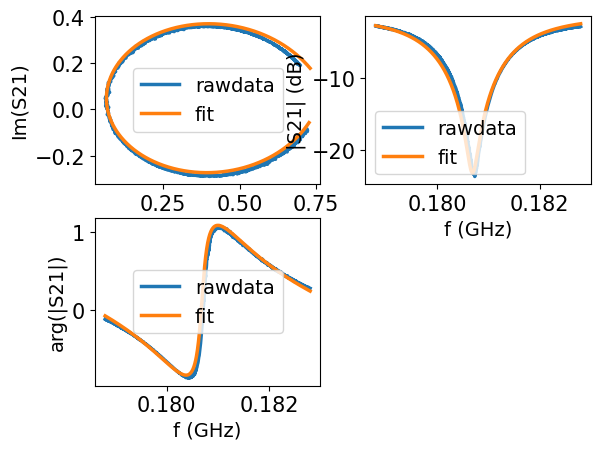

In [63]:
from resonator_tools import circuit
f, complex_data = get_complex_Sparam(SSA, trace=1)
plot_S11_fit(f, complex_data)

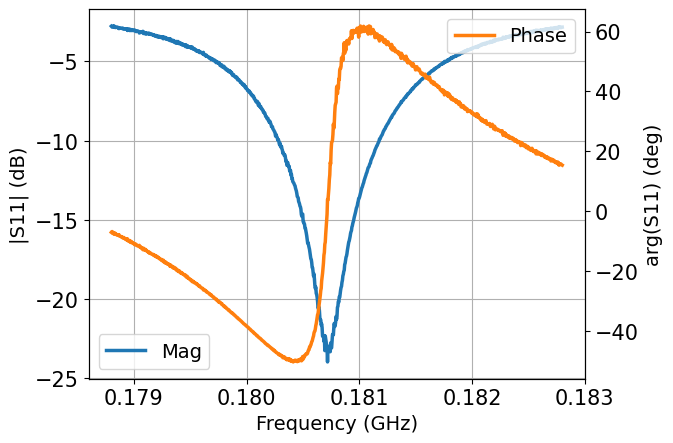

In [64]:
f, mag, phase = measure_and_plot_S11(SSA)

In [66]:
np.savez('resonator_10_17.npz', f=f, complex_data=complex_data, mag=mag, phase=phase)

In [28]:
vna = SSA

# Make sure VNA mode is active
vna.write(":INSTrument:SELect VNA")
vna.write(":INITiate:IMMediate")

vna.write(":CALCulate1:PARameter1:SELect ")
vna.write(":CALCulate1:FORMat MLOGarithmic")

data_str = vna.query(":CALCulate1:DATA:FDATa?")
data = np.array(data_str.strip().split(','), dtype=float)
f, S11_mag = data[0::2], data[1::2]
vna.write(":CALCulate1:PARameter2:SELect ")
vna.write(":CALCulate1:FORMat MLOGarithmic")
data_str = vna.query(":CALCulate1:DATA:FDATa?")
data = np.array(data_str.strip().split(','), dtype=float)
f, S21_mag = data[0::2], data[1::2]

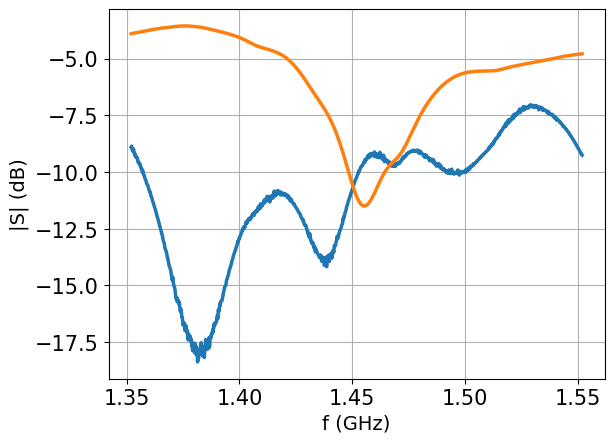

In [29]:
plot(f/1e9, S11_mag, label='S11')
plot(f/1e9, S21_mag, xlabel='f (GHz)', ylabel='|S| (dB)', label='S21')

In [24]:
f, complex_data = get_complex_Sparam(SSA, trace=2)

Fit results: {'Qi_dia_corr': np.float64(50.21730911232314), 'Qi_no_corr': np.float64(53.50872783941744), 'absQc': np.float64(34.98230879960826), 'Qc_dia_corr': np.float64(36.548418316630745), 'Ql': np.float64(21.153089757422755), 'fr': np.float64(1449660063.5920248), 'theta0': np.float64(-2.847791094070337), 'phi0': np.float64(0.29380210324096306), 'phi0_err': np.float64(0.0067037807038545436), 'Ql_err': np.float64(0.16603248829870831), 'absQc_err': np.float64(0.17321511801007305), 'fr_err': np.float64(242629.0611559251), 'chi_square': np.float64(0.0008274848314988241), 'Qi_no_corr_err': np.float64(0.7989765172915937), 'Qi_dia_corr_err': np.float64(0.6860011410385988)}


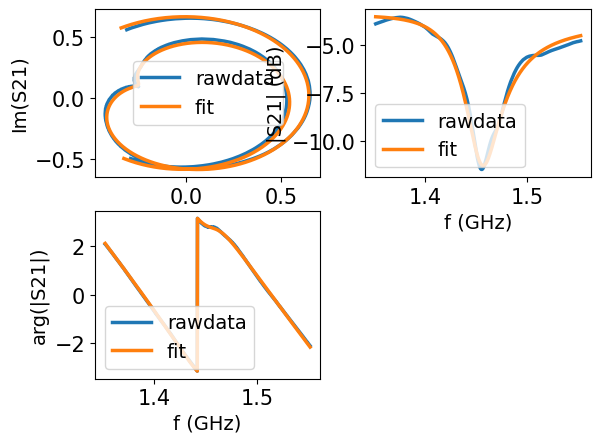

single photon limit: -127.47970781401519 dBm
photons in reso for input -140dBm: 0.055971994321686966 photons
done


In [25]:
from resonator_tools import circuit
port1 = circuit.notch_port()
port1.add_data(f,complex_data)
port1.autofit()
print("Fit results:", port1.fitresults)
port1.plotall()
print("single photon limit:", port1.get_single_photon_limit(), "dBm")
print("photons in reso for input -140dBm:", port1.get_photons_in_resonator(-140,unit='dBm'), "photons")
print("done")

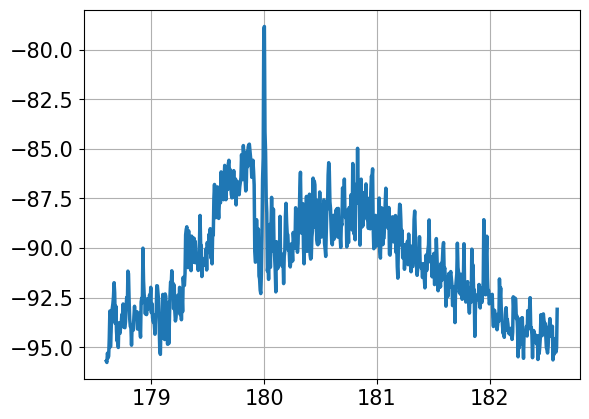

In [73]:
data_str_C = SSA.query(":TRACe2:DATA?")
data_arr_C = np.array([float(val) for val in data_str_C.split(',')])
freq_start = 178.6 
freq_stop = 182.6 
f = np.linspace(freq_start, freq_stop, len(data_arr_C)) 
plot(f, data_arr_C)

In [74]:
Q = 1600
Ic = 0.56 
Vrf = 90 
Zr = Vrf / Ic 

Zr0 = 50

0.10044642857142856

In [81]:
Zr0 = 2000 
Zr = Q*Zr0
Ic = 0.5 
Vrf = 60
Ic = Vrf/Zr*Q

In [82]:
Ic

0.03